In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tejashvi14/employee-future-prediction")

print("Path to dataset files:", path)

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/tejashvi14/employee-future-prediction/versions/1


In [3]:
df = pd.read_csv('Employee.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.shape


(4653, 9)

In [4]:
df.head()
#df['pages']

,education,joiningyear,city,paymenttier,age,gender,everbenched,experienceincurrentdomain,leaveornot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


Stage: Cleanup and EDA

In [5]:
df.isnull().sum()


education                    0
joiningyear                  0
city                         0
paymenttier                  0
age                          0
gender                       0
everbenched                  0
experienceincurrentdomain    0
leaveornot                   0
dtype: int64

See Distribution

Feature importnace

In [6]:
df.columns


Index(['education', 'joiningyear', 'city', 'paymenttier', 'age', 'gender',
       'everbenched', 'experienceincurrentdomain', 'leaveornot'],
      dtype='object')

In [7]:
categorical_col = df.select_dtypes(include=['object']).columns
print(categorical_col)

Index(['education', 'city', 'gender', 'everbenched'], dtype='object')


In [8]:
numerical_col = df.select_dtypes(exclude=['object']).columns
print(numerical_col)

Index(['joiningyear', 'paymenttier', 'age', 'experienceincurrentdomain',
       'leaveornot'],
      dtype='object')


In [9]:

from sklearn.metrics import mutual_info_score
def mutual_info_rating_score(series):
    return mutual_info_score(series, df.leaveornot)
mi = df[categorical_col].apply(mutual_info_rating_score)
mi.sort_values(ascending=False).round(6)

gender         0.024192
city           0.021632
education      0.010592
everbenched    0.002969
dtype: float64

In [10]:
numerical_col = numerical_col.drop("leaveornot")
df[numerical_col].corrwith(df.leaveornot).abs().sort_values(ascending=False)


paymenttier                  0.197638
joiningyear                  0.181705
age                          0.051126
experienceincurrentdomain    0.030504
dtype: float64

Stage: Model Training 

Split data into train validation and test

In [11]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(2791, 931, 931)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.leaveornot.values
y_val = df_val.leaveornot.values
y_test = df_test.leaveornot.values

del df_train['leaveornot']
del df_val['leaveornot']
del df_test['leaveornot']

One-hot encoding

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE  # If using SMOTE for class imbalance

dv = DictVectorizer(sparse=False)



train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)


Training logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
#model = LogisticRegression(solver='liblinear', C=1, max_iter=10, random_state=42)
#model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.1, random_state=42, max_iter=1)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [15]:
y_val_probs = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_probs)
print(auc)



0.694122995102058


In [16]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [17]:
dv, model = train(df_train, y_train)
y_pred =  predict(df_val, dv, model)
roc_auc_score(y_val, y_pred)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.694122995102058)

In [18]:
df_full_train

,education,joiningyear,city,paymenttier,age,gender,everbenched,experienceincurrentdomain,leaveornot
1344,Masters,2012,New Delhi,3,26,Female,No,4,1
3019,Bachelors,2013,Pune,3,37,Male,No,0,0
3424,Bachelors,2013,Bangalore,3,39,Male,No,2,0
1528,Bachelors,2014,Pune,2,25,Female,No,3,1
1399,Bachelors,2017,Bangalore,1,28,Female,No,3,0
...,...,...,...,...,...,...,...,...,...
2895,Bachelors,2017,New Delhi,2,28,Male,No,2,0
2763,Bachelors,2017,Bangalore,3,27,Male,No,5,1
905,Masters,2017,Bangalore,3,28,Male,No,1,1
3980,Bachelors,2018,Bangalore,3,38,Male,No,6,1


Cross-Validation with kfold

In [19]:
from sklearn.model_selection import KFold
n_splits = [3, 10, 15, 20, 25]
#n_splits = [10]
df_full_train_k_fold = df_full_train
auc_list = []
for n_split in n_splits: 
    kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_k_fold = df_full_train_k_fold.iloc[train_idx]
        df_val_k_fold = df_full_train_k_fold.iloc[val_idx]

        y_train_k_fold = df_train_k_fold.leaveornot.values
        y_val_k_fold = df_val_k_fold.leaveornot.values
        del df_train_k_fold['leaveornot']
        del df_val_k_fold['leaveornot']
        dv, model = train(df_train_k_fold, y_train_k_fold)
        y_pred = predict(df_val_k_fold, dv, model)
        

    #print(roc_auc_score(y_val_k_fold, y_pred))
    auc = roc_auc_score(y_val_k_fold, y_pred)
    auc_list.append(auc)



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [20]:
print(auc_list)

[np.float64(0.7152993657408989), np.float64(0.6998272517880956), np.float64(0.7216094346167188), np.float64(0.717948717948718), np.float64(0.7219941348973606)]


In [21]:
df['leaveornot'].describe()
count = (df['leaveornot'] == 1).sum()
print(count)

1600


Training random forest regressor


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.8652645519329003)

In [23]:
max_depth = 10
scores = []
auc_list = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))
        auc_list.append(auc)
print(max(auc_list))        

0.8857103066994598


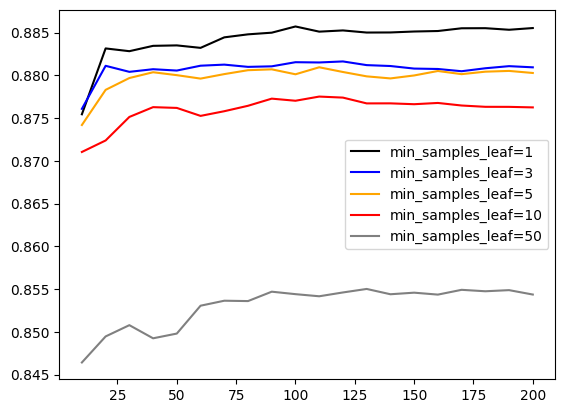

In [24]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [25]:
min_samples_leaf = 1

In [26]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=1)

In [27]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(auc)

0.8855263711084483


XGBoost

In [28]:
import xgboost as xgb
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [29]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [30]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8829959429063925)

Try to tune few parameters

In [31]:
etas = [0.01, 0.3, 1]
max_depths = [1, 3, 6]
min_child_weights = [1, 10, 30]
scores = []
for eta in etas:
    for max_depth in max_depths:
        for min_child_weight in min_child_weights:
            xgb_params['eta'] = eta
            xgb_params['max_depth'] = max_depth
            xgb_params['min_child_weight']=min_child_weight
            model = xgb.train(xgb_params, dtrain, num_boost_round=10)
            y_pred = model.predict(dval)
            auc = roc_auc_score(y_val, y_pred)
            scores.append((eta, max_depth, min_child_weight, auc))
# Find the element with the maximum auc
max_auc_element = max(scores, key=lambda x: x[-1])

# Print the result
print("Element with maximum AUC:", max_auc_element)

Element with maximum AUC: (0.3, 6, 1, np.float64(0.8829959429063925))


Stage: Selecting the best model.

Random forest model is giving slightly better results. 

Lets use it to check with test data once.

In [32]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.leaveornot.values
del df_full_train['leaveornot']
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

#rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)


np.float64(0.8683311074838007)